<a href="https://colab.research.google.com/github/mrudulamadhavan/Mrudula_Scifor/blob/main/week%2011/ML_Implementation_Test_14_March.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Algorithms Implementation - Test

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets

## 1. Implement Decision Tree Classifier by applying HyperParameter Tuning




In [2]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < self.min_samples_split:
            return Counter(y).most_common(1)[0][0]

        # Find best split
        best_idx, best_thr = None, None
        best_gini = 1.0
        for idx in range(n_features):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            for i in range(1, n_samples):
                if classes[i - 1] != classes[i]:
                    thr = (thresholds[i - 1] + thresholds[i]) / 2
                    y_left = y[X[:, idx] <= thr]
                    y_right = y[X[:, idx] > thr]
                    gini = self._gini(y_left, y_right)
                    if gini < best_gini:
                        best_idx = idx
                        best_thr = thr
                        best_gini = gini

        if best_gini == 1.0:
            return Counter(y).most_common(1)[0][0]

        # Recursive split
        left_idx = X[:, best_idx] <= best_thr
        X_left, y_left = X[left_idx], y[left_idx]
        X_right, y_right = X[~left_idx], y[~left_idx]
        left = self._grow_tree(X_left, y_left, depth + 1)
        right = self._grow_tree(X_right, y_right, depth + 1)
        return {'feature': best_idx, 'threshold': best_thr, 'left': left, 'right': right}

    def _gini(self, *groups):
        total_samples = sum(len(group) for group in groups)
        gini = 0.0
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            score = 0
            for label in np.unique(group):
                p = (group == label).sum() / size
                score += p * p
            gini += (1.0 - score) * (size / total_samples)
        return gini

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        node = self.tree_
        while isinstance(node, dict):
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


# Hyperparameter Tuning
def tune_hyperparameters(X_train, y_train, X_val, y_val, max_depths, min_samples_splits, min_samples_leafs):
    best_score = 0
    best_params = {}
    for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
            for min_samples_leaf in min_samples_leafs:
                clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                clf.fit(X_train, y_train)
                score = clf.score(X_val, y_val)
                if score > best_score:
                    best_score = score
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
    return best_params

# Testing
if __name__ == "__main__":

    # Generate sample data
    X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=123)

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

    # Hyperparameter Tuning
    max_depths = [5,8 ,10, 20, 30]
    min_samples_splits = [2, 5,8, 10,12]
    min_samples_leafs = [1, 2,3, 4,5]
    best_params = tune_hyperparameters(X_train, y_train, X_val, y_val, max_depths, min_samples_splits, min_samples_leafs)

    # Train with best hyperparameters
    clf = DecisionTreeClassifier(**best_params)
    clf.fit(X_train, y_train)

    # Evaluate on test set
    accuracy = clf.score(X_test, y_test)
    print("Best Accuracy:", accuracy * 100, "%")
    print("Best Hyperparameters:", best_params)


Best Accuracy: 98.0 %
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}



## 2. Implement Naive's Bayes Classifier by Applying HyperParameter Tuning



In [3]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0) + self.alpha  # Add smoothing
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

# Testing
if __name__ == "__main__":
    # Generate sample data
    X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=123)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # Define hyperparameter values to search through
    alphas = [0.1, 0.5, 1.0, 2.0, 5.0]  # Smoothing parameter values

    best_accuracy = 0
    best_alpha = None

    # Perform hyperparameter tuning
    for alpha in alphas:
        nb = NaiveBayes(alpha=alpha)
        nb.fit(X_train, y_train)
        preds = nb.predict(X_test)
        acc = accuracy(y_test, preds)
        if acc > best_accuracy:
            best_accuracy = acc
            best_alpha = alpha

    print("Best Alpha:", best_alpha)
    print("Best Accuracy:", best_accuracy * 100, "%")


Best Alpha: 0.1
Best Accuracy: 96.0 %


## 3. Implement Support Vector Machine by applying HyperParameter Tuning



In [4]:
class SupportVectorMachine:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.learning_rate * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


# Hyperparameter Tuning
def tune_hyperparameters(X_train, y_train, X_val, y_val, learning_rates, lambda_params, n_iters_list):
    best_score = 0
    best_params = {}
    for learning_rate in learning_rates:
        for lambda_param in lambda_params:
            for n_iters in n_iters_list:
                svm = SupportVectorMachine(learning_rate=learning_rate, lambda_param=lambda_param, n_iters=n_iters)
                svm.fit(X_train, y_train)
                score = svm.score(X_val, y_val)
                if score > best_score:
                    best_score = score
                    best_params = {'learning_rate': learning_rate, 'lambda_param': lambda_param, 'n_iters': n_iters}
    return best_params

# Testing
if __name__ == "__main__":

    # Generate sample data
    X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=123)

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

    # Hyperparameter Tuning
    learning_rates = [0.01, 0.001, 0.0001]
    lambda_params = [0.01, 0.1,0.5, 1]
    n_iters_list = [300,500,800,1000,1500, 2000, 3000]
    best_params = tune_hyperparameters(X_train, y_train, X_val, y_val, learning_rates, lambda_params, n_iters_list)

    # Train with best hyperparameters
    svm = SupportVectorMachine(**best_params)
    svm.fit(X_train, y_train)

    # Evaluate on test set
    accuracy = round(svm.score(X_test, y_test),4)
    print("Best Accuracy:", accuracy * 100, "%")
    print("Best Hyperparameters:", best_params)


Best Accuracy: 50.67 %
Best Hyperparameters: {'learning_rate': 0.01, 'lambda_param': 0.01, 'n_iters': 500}


# 4. Explain various types of  Kernels with respect to the formula

 SVM algorithms use a set of mathematical functions that are defined as the kernel. The function of kernel is to take data as input and implicitly map the input vectors into a higher-dimensional space where the data may be linearly separable, even if it's not in the original feature space. This allows SVMs to effectively handle non-linear decision boundaries.

 Different SVM algorithms use different types of kernel functions. These functions can be different types. For example linear, nonlinear, polynomial, radial basis function (RBF), and sigmoid.

 ### **Common Types of Kernels used in SVM**

 **1) Linear Kernel**

* simplest kernel
* used for linearly separable data or when the number of features is very high.

For two input vectors x1 and x2, Linear kernel function is given by,


 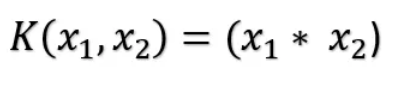

 **2) Polynomial Kernel**

The polynomial kernel calculates the similarity between two vectors as the polynomial of the dot product of the vectors, raising it to a specified power.

For two input vectors x1 and x2, polynomial kernel function is given by,

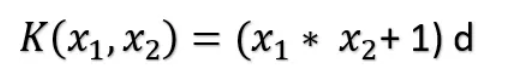

Here d is the degree of the polynomial.

**3) Gaussian Radial Basis Function (RBF) Kernel**

The Gaussian RBF kernel is a popular choice for SVMs because it allows modeling non-linear decision boundaries.

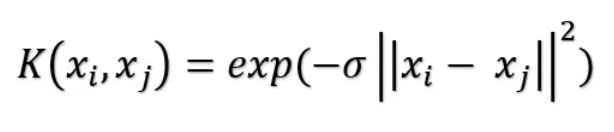

Here, γ is a hyperparameter that controls the influence of each training example.


**4) Exponential Kernel**

This is in close relation with the previous kernel i.e. the Gaussian kernel with the only difference is — the square of the norm is removed.

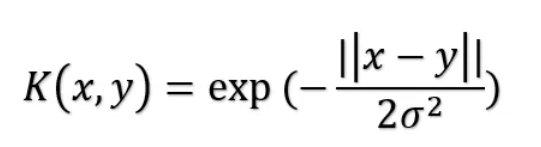

**5) Sigmoid Kernel**

The sigmoid kernel calculates the similarity between two vectors using the hyperbolic tangent function.This kernel is used in neural network areas of machine learning. The activation function for the sigmoid kernel is the bipolar sigmoid function.

The equation for the hyperbolic kernel function is given by,

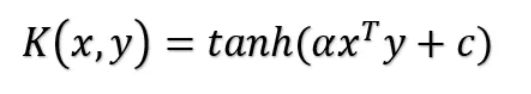

This kernel is very much used and popular among support vector machines.




----------------------------------------------------------------------

**Submitted by : Mrudula A P**